In [1]:
import os
import warnings
from itertools import product
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager
from qiskit.visualization import plot_error_map
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AERSamplerV2

from qiskit_ibm_runtime.fake_provider import FakeLondonV2, FakeMelbourneV2, FakeAlmadenV2 
from qiskit_ibm_runtime import SamplerV2, EstimatorV2

from qiskit_addon_cutting import cut_gates, generate_cutting_experiments,reconstruct_expectation_values


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from utils import export_data_json, generate_output_dir, generate_full_file_path, import_json_data

In [2]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'ghz-test')
generate_output_dir(OUTPUT_PATH)

/home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test already exists!


In [3]:
SHOTS = 1000

In [4]:
london = FakeLondonV2()
melbourne = FakeMelbourneV2()
almaden = FakeAlmadenV2()

print("Number of qubits per baceknd")
print(f"London V2: {london.num_qubits}")
print(f"Melbourne V2: {melbourne.num_qubits}")
print(f"Almaden V2: {almaden.num_qubits}")

Number of qubits per baceknd
London V2: 5
Melbourne V2: 15
Almaden V2: 20


In [5]:
_5_qubits = london
_15_qubits = melbourne
_20_qubits = almaden

London Coupling map and error map


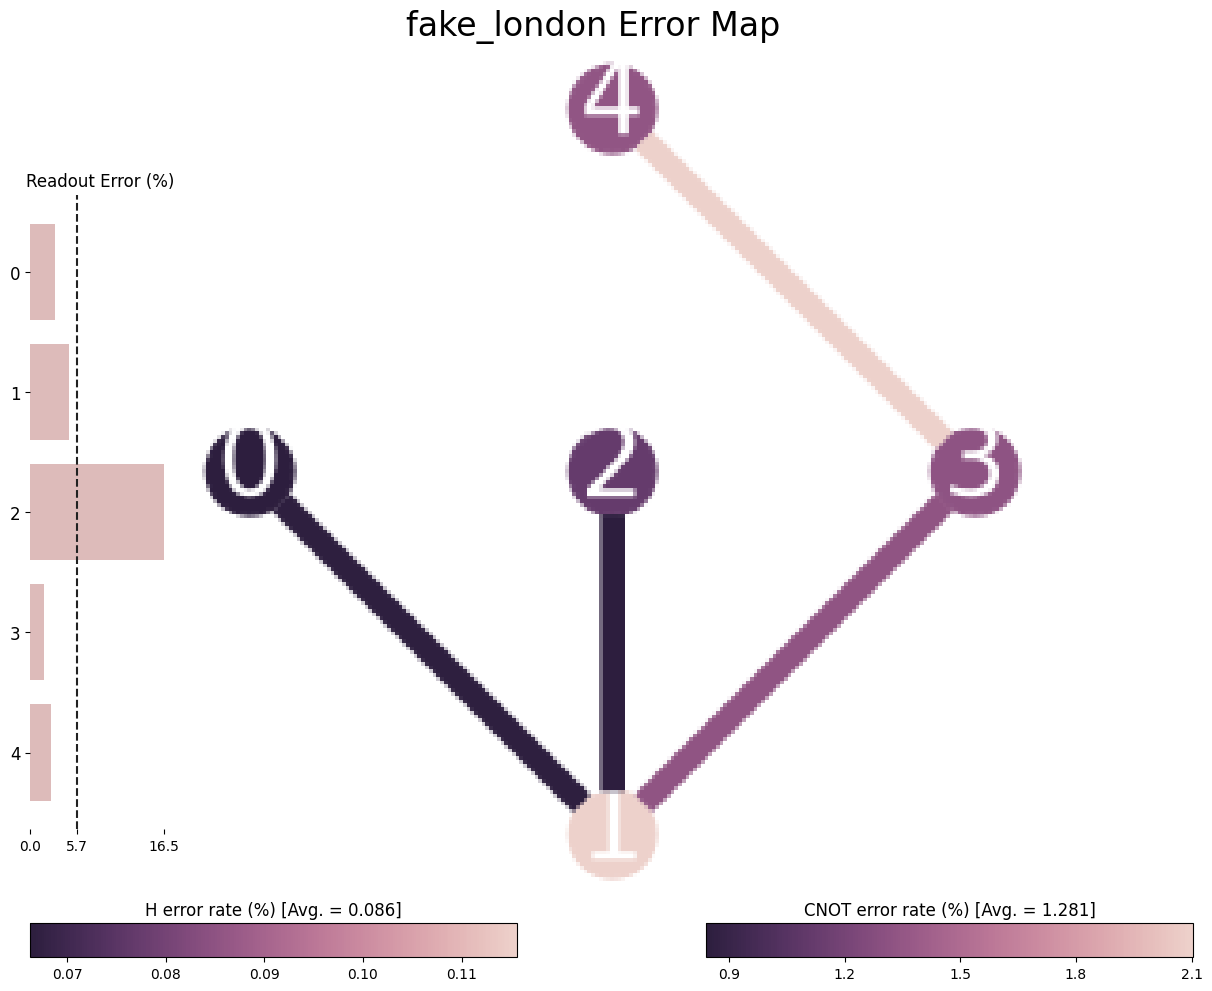

In [7]:
print("London Coupling map and error map")
fig = plot_error_map(_5_qubits)
fig.savefig(generate_full_file_path(OUTPUT_PATH, "error-map-london-v2-backend.png"))
display(fig)

Melbourne Coupling map and error map


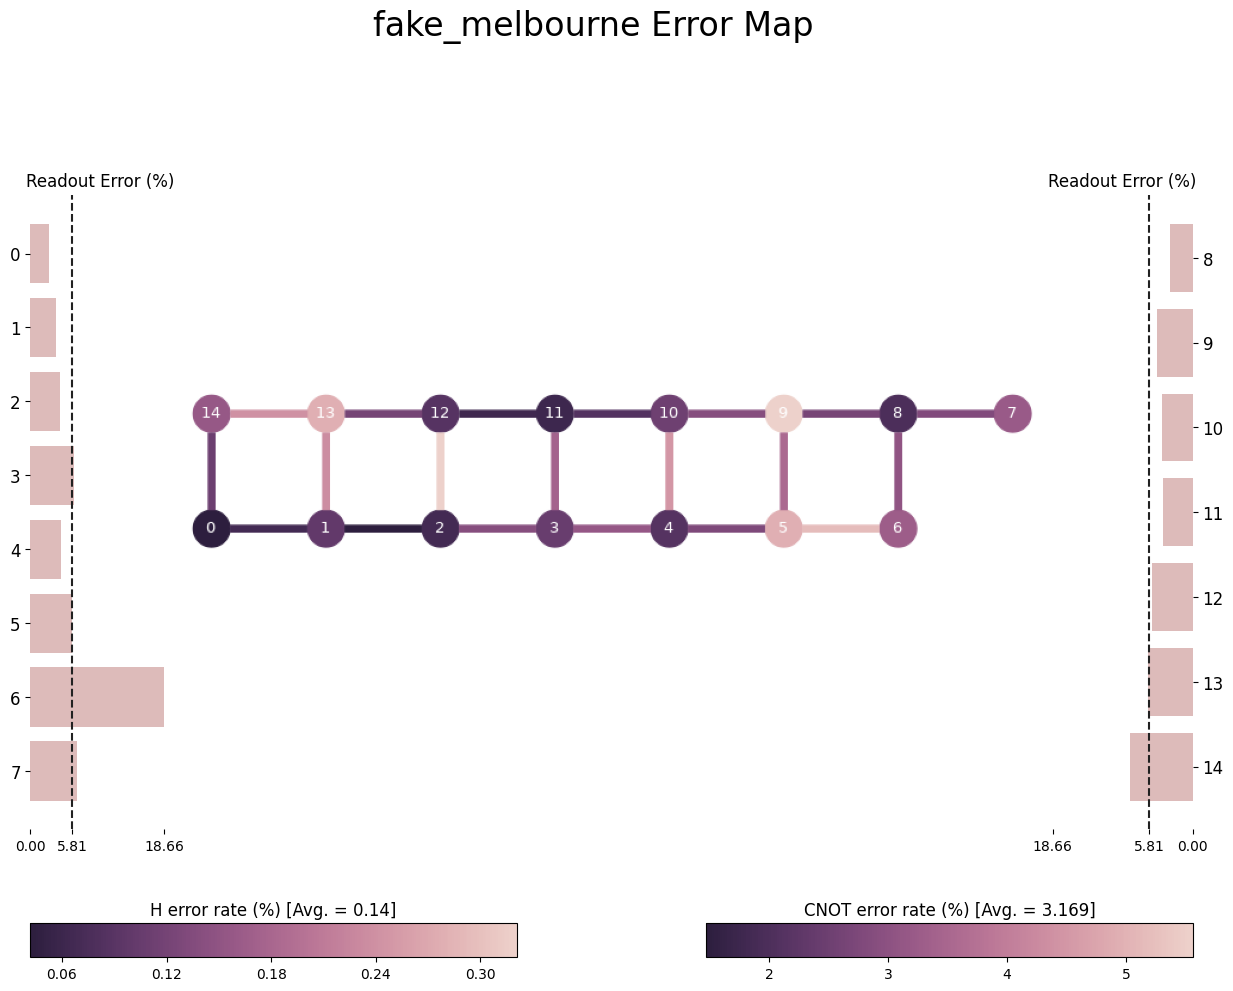

In [8]:
print("Melbourne Coupling map and error map")
fig = plot_error_map(_15_qubits)
fig.savefig(generate_full_file_path(OUTPUT_PATH, "error-map-melbourne-v2-backend.png"))
display(fig)

Almaden Coupling map


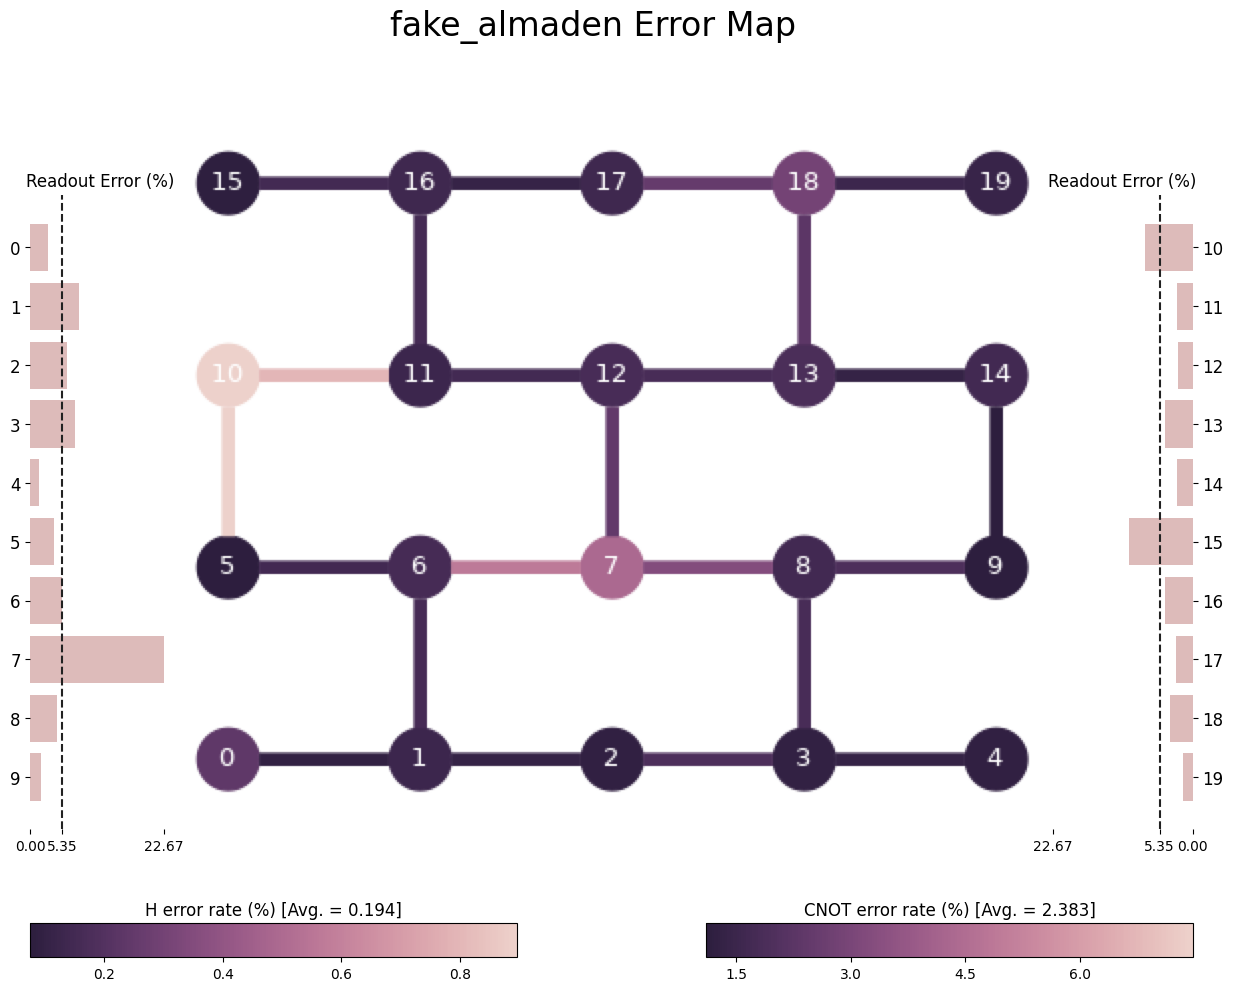

In [9]:
print("Almaden Coupling map")
fig = plot_error_map(_20_qubits)
fig.savefig(generate_full_file_path(OUTPUT_PATH, "error-map-almaden-v2-backend.png"))
display(fig)

In [6]:
def generate_simple_ghz(n_qubits):
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(n_qubits-1):
        qc.cx(i, i+1)
    qc.measure_all()

    return qc

In [7]:
def amount_of_errors_ghz(results, shots=SHOTS, percentage=False):
    errors = {
        "correct":0,
        "wrong":0
    }

    size = len(list(results.keys())[0])
    target_bitstrings = ('0'*size, '1'*size)

    for target in target_bitstrings:
        from_data = results.get(target)
        errors["correct"] += results[target] if from_data is not None else 0

    errors['wrong'] = shots - errors["correct"]

    if not percentage:
        return errors
    
    return {
        "correct": errors["correct"]/shots,
        "wrong": errors["wrong"]/shots
    }
    

In [6]:
def get_counts(circuit, backend, opt=0, shots=SHOTS):
    pm = generate_preset_pass_manager(optimization_level=opt, backend=backend)
    sampler = AERSamplerV2(options={"backend_options":{'method':'statevector','device':'GPU'}}).from_backend(backend)

    isa_qc = pm.run(circuit)
    return sampler.run([isa_qc], shots=shots).result()[0].data.meas.get_counts()

In [7]:
ghz_circuits = [
    generate_simple_ghz(5),
    generate_simple_ghz(15),
    generate_simple_ghz(20)
]

In [8]:
backends = [
    _5_qubits,
    _15_qubits,
    _20_qubits
]

In [12]:
get_result_path = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"results-no-mitigation-{backend_name}-with-{n_qubits}-qubits.json")

In [ ]:
experiments_results = []
for index, (circuit, backend) in enumerate(zip(ghz_circuits, backends)):
    n_qubits = backend.num_qubits
    backend_name = backend.name

    print(f"Running {index+1} experiment on {backend_name} with {n_qubits} qubits")
    results = get_counts(circuit,backend)
    export_data_json(results, get_result_path(n_qubits, backend_name))
    experiments_results.append(results)

Running 1 experiment on fake_london with 5 qubits
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_london-with-5-qubits.json...
Running 2 experiment on fake_melbourne with 15 qubits
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_melbourne-with-15-qubits.json...
Running 3 experiment on fake_almaden with 20 qubits
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_almaden-with-20-qubits.json...


---

In [13]:
amount_of_errors = pd.DataFrame(columns=['label', 'errors'])

for i,backend in enumerate(backends):
    backend_name = backend.name
    n_qubits = backend.num_qubits

    file_path = get_result_path(n_qubits, backend_name)
    data = import_json_data(file_path)
    errors = amount_of_errors_ghz(data)
    print(errors)

    label = f'{backend_name} - {n_qubits} qubits'
    amount_of_errors.loc[i] = {'label':label, 'errors':errors['wrong']}

    export_data_json(errors, generate_full_file_path(OUTPUT_PATH, f"amount-of-errors-no-mitigation-{backend_name}-with-{n_qubits}-qubits.json"))

Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_london-with-5-qubits.json
{'correct': 716, 'wrong': 284}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/amount-of-errors-no-mitigation-fake_london-with-5-qubits.json...
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_melbourne-with-15-qubits.json
{'correct': 288, 'wrong': 712}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/amount-of-errors-no-mitigation-fake_melbourne-with-15-qubits.json...
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-no-mitigation-fake_almaden-with-20-qubits.json
{'correct': 110, 'wrong': 890}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/amount-of-errors-no-mitigation-fake_almaden-with-20-qubits.json...


In [14]:
palette = sns.color_palette("tab10")

/tmp/ipykernel_428860/3030830550.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  plot = sns.barplot(x="label", y="errors", data=amount_of_errors, hue="errors", legend=False, palette=palette)


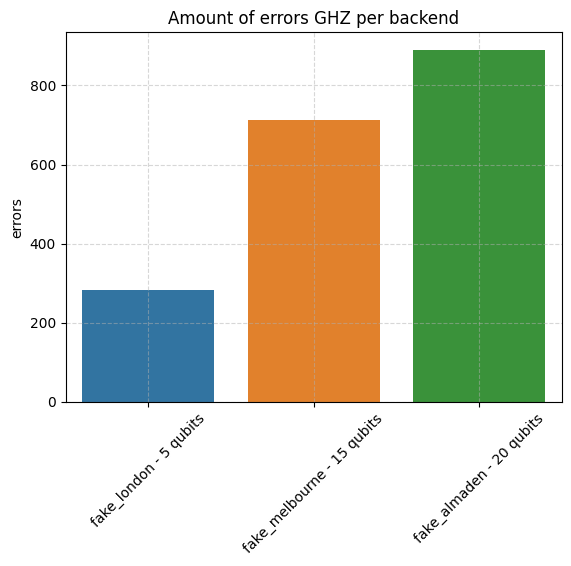

In [15]:
plot = sns.barplot(x="label", y="errors", data=amount_of_errors, hue="errors", legend=False, palette=palette)
plot.set(xlabel="")
plt.grid(linestyle="--",alpha=0.5,zorder=1)
plt.title("Amount of errors GHZ per backend")
plt.tick_params(axis='x', rotation=45)
plt.savefig(generate_full_file_path(OUTPUT_PATH, "amount-of-errors-no-mitigation-fackbackends-ghz.png"), bbox_inches='tight')
plt.show()

In [16]:
get_result_path_mitigation = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"results-mitigation-3-{backend_name}-with-{n_qubits}-qubits.json")
get_errors_path_mitigation = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"errors-mitigation-3-{backend_name}-with-{n_qubits}-qubits.json")

In [ ]:
for index, (circuit, backend) in enumerate(zip(ghz_circuits, backends)):
    n_qubits = backend.num_qubits
    backend_name = backend.name

    print(f"Running {index+1} experiment on {backend_name} with {n_qubits} qubits (mitigation level=3)")

    results = get_counts(circuit,backend,opt=3)
    export_data_json(results, get_result_path_mitigation(n_qubits, backend_name))

    errors = amount_of_errors_ghz(results)
    export_data_json(errors, get_errors_path_mitigation(n_qubits, backend_name))

Running 1 experiment on fake_london with 5 qubits (mitigation level=3)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-mitigation-3-fake_london-with-5-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_london-with-5-qubits.json...
Running 2 experiment on fake_melbourne with 15 qubits (mitigation level=3)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-mitigation-3-fake_melbourne-with-15-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_melbourne-with-15-qubits.json...
Running 3 experiment on fake_almaden with 20 qubits (mitigation level=3)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-mitigation-3-fake_almaden-with-20-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake

---

In [ ]:
amount_of_errors_mitigation = pd.DataFrame(columns=['label', 'errors'])

for i,backend in enumerate(backends):
    backend_name = backend.name
    n_qubits = backend.num_qubits

    errors = import_json_data(get_errors_path_mitigation(n_qubits, backend_name))
    print(errors)

    label = f'{backend_name} - {n_qubits} qubits'
    amount_of_errors_mitigation.loc[i] = {'label':label, 'errors':errors['wrong']}

Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_london-with-5-qubits.json
{'correct': 711, 'wrong': 289}
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_melbourne-with-15-qubits.json
{'correct': 294, 'wrong': 706}
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-mitigation-3-fake_almaden-with-20-qubits.json
{'correct': 210, 'wrong': 790}


/tmp/ipykernel_428860/451366516.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot = sns.barplot(data=resulting_data, x="label", y="errors", hue="mitigation", palette=palette, legend="auto")


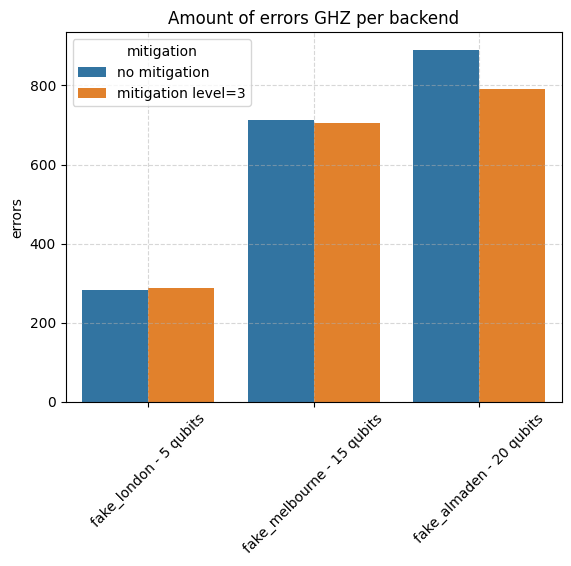

In [18]:
resulting_data = pd.concat([amount_of_errors, amount_of_errors_mitigation])
resulting_data['mitigation'] = ['no mitigation','no mitigation','no mitigation','mitigation level=3','mitigation level=3','mitigation level=3']

plot = sns.barplot(data=resulting_data, x="label", y="errors", hue="mitigation", palette=palette, legend="auto")
plot.set(xlabel="")
plt.title("Amount of errors GHZ per backend")
plt.grid(linestyle="--",alpha=0.5,zorder=1)
plt.tick_params(axis='x', rotation=45)
plt.savefig(generate_full_file_path(OUTPUT_PATH, "amount-of-errors-no-mitigation-fackbackends-ghz-compartion-between-no-migation-and-mitigation-3.png"), bbox_inches='tight')
plt.show()


---

In [11]:
get_results_incresead_shots = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"results-increased-shots-{backend_name}-with-{n_qubits}-qubits.json")
get_errors_path_incresead_shots = lambda n_qubits, backend_name: generate_full_file_path(OUTPUT_PATH, f"errors-increased-shots-{backend_name}-with-{n_qubits}-qubits.json")

In [12]:
shots = 8000

for index, (circuit, backend) in enumerate(zip(ghz_circuits, backends)):
    n_qubits = backend.num_qubits
    backend_name = backend.name

    print(f"Running {index+1} experiment on {backend_name} with {n_qubits} qubits (increased shots to {shots})")
    
    results = get_counts(circuit,backend,opt=3,shots=shots)
    export_data_json(results, get_results_incresead_shots(n_qubits, backend_name))

    errors = amount_of_errors_ghz(results, shots=shots)
    export_data_json(errors, get_errors_path_incresead_shots(n_qubits, backend_name))

Running 1 experiment on fake_london with 5 qubits (increased shots to 8000)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-increased-shots-fake_london-with-5-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-increased-shots-fake_london-with-5-qubits.json...
Running 2 experiment on fake_melbourne with 15 qubits (increased shots to 8000)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-increased-shots-fake_melbourne-with-15-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/errors-increased-shots-fake_melbourne-with-15-qubits.json...
Running 3 experiment on fake_almaden with 20 qubits (increased shots to 8000)
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/results-increased-shots-fake_almaden-with-20-qubits.json...
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz

---

In [9]:
def ghz_estimate(qc, backend, methods):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    estimator = EstimatorV2(mode=backend)

    zne = methods.get('zne') or False
    meas = methods.get('meas') or False
    ddp = methods.get('ddp') or False
    pt = methods.get('pt') or False
    pea = methods.get('pea') or False
    pec = methods.get('pec') or False

    if zne:
        estimator.options.resilience.zne_mitigation = True
        estimator.options.resilience.zne.noise_factors = (1,3,5,7,11)
        estimator.options.resilience.zne.extrapolator = "exponential"

    if meas:
        estimator.options.resilience.measure_mitigation = True
        estimator.options.resilience.measure_noise_learning.num_randomizations = 32
        estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

    if ddp:
        estimator.options.dynamical_decoupling.enable = True
        estimator.options.dynamical_decoupling.sequence_type = "XpXm"

    if pt:
        estimator.options.twirling.enable_gates = True
        estimator.options.twirling.num_randomizations = 32
        estimator.options.twirling.shots_per_randomization = 100

    if pea:
        estimator.options.resilience.zne_mitigation = True
        estimator.options.resilience.zne.amplifier = "pea"

    if pec:
        estimator.options.resilience.pec_mitigation = True
        estimator.options.resilience.pec.max_overhead = 100

    n_qubits = qc.num_qubits
    obs = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(n_qubits)], num_qubits=n_qubits)


    isa_qc = pm.run(qc)
    isa_observable = obs.apply_layout(isa_qc.layout)


    return estimator.run([(isa_qc, isa_observable,)]).result()[0]

In [9]:
out_files = []

In [12]:
def run_experiment(comb, out_files):
    methods = ['zne', 'meas', 'ddp', 'pt', 'pea', 'pec']

    has_mitigation = any(comb)
    mitigation_methods = '-no-mitigation'
    
    methods_arg = {}
    if(has_mitigation):
        mitigation_methods = ''
        for i,use in enumerate(comb):
            if use:
                method = methods[i]
                mitigation_methods += f'-{method}'
                methods_arg[method] = True

    file_path = generate_full_file_path(OUTPUT_PATH, f"estimation{mitigation_methods}.json")

    out_files.append(file_path)

    estimation_data = {}

    for circuit,backend in zip(ghz_circuits, backends):
        label = f'{backend.name}_{backend.num_qubits}'
        print(f"Running Experiment: {label}")
        result = ghz_estimate(circuit, backend, methods_arg)
        estimation_data[label] = float(result.data.evs[()])

    export_data_json(estimation_data, file_path)

In [11]:
combinations = [comb for comb in product([True, False], repeat=3)]

In [39]:
for comb in combinations:
    print(f"Using comb: {comb}")
    run_experiment(comb, out_files)

Using comb: (True, True, True)
Running Experiment: fake_london_5


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-meas-ddp.json...
Using comb: (True, True, False)
Running Experiment: fake_london_5


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-meas.json...
Using comb: (True, False, True)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-ddp.json...
Using comb: (True, False, False)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne.json...
Using comb: (False, True, True)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode

Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas-ddp.json...
Using comb: (False, True, False)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas.json...
Using comb: (False, False, True)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-ddp.json...
Using comb: (False, False, False)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15
Running Experiment: fake_almaden_20
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-no-mitigation.json...


In [28]:
comparasions_paths_file_path = generate_full_file_path(OUTPUT_PATH, "migiation-methods-comparasion.json")

In [31]:
export_data_json(out_files, comparasions_paths_file_path)

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/migiation-methods-comparasion.json...


In [32]:
data_paths = import_json_data(comparasions_paths_file_path)

Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/migiation-methods-comparasion.json


In [34]:
estimation_data = pd.DataFrame(columns=("experiment", "expval", "mitigation"))
df_row_i = 0

for path in data_paths:

    mitigation = path.split('/')[-1].replace('estimation-', '').replace('.json', '').replace('-', ' ').title()
    if not 'No' in mitigation:
        mitigation = mitigation.replace(' ', ' + ')

    data = import_json_data(path)

    for k,v in data.items():
        estimation_data.loc[df_row_i] = {"experiment":k, "expval":v, "mitigation":mitigation}
        df_row_i += 1


Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-meas-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-meas.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-no-mitigation.json


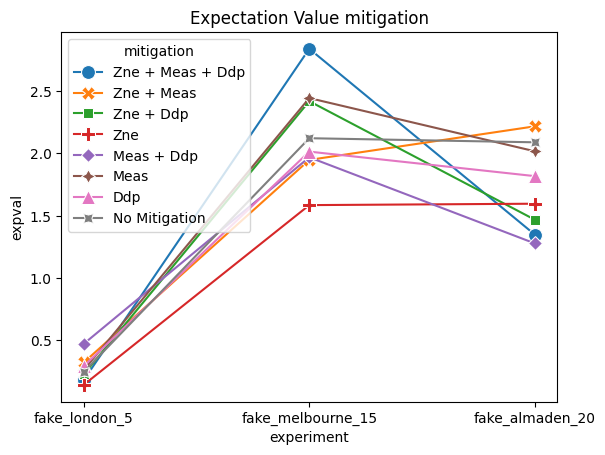

In [35]:
sns.lineplot(data=estimation_data, x="experiment", y="expval", hue="mitigation", markers=True, dashes=False, style="mitigation", markersize=10)
plt.title("Expectation Value mitigation")
plt.savefig(generate_full_file_path(OUTPUT_PATH, "mitgation-expval-comparasion.png"), bbox_inches='tight')
plt.show()

---

In [22]:
# ['zne', 'meas', 'ddp', 'pt', 'pea', 'pec']
final_experiments = [
    (True, False, True, True),
    (False, False, True, True, True),
    (False, True, True, True, False, True)
]

In [23]:
out_files = []

In [25]:
for comb in final_experiments:
    print(f"Using comb: {comb}")
    run_experiment(comb, out_files)

Using comb: (True, False, True, True)
Running Experiment: fake_london_5


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0, 7.0, 11.0), 'extrapolator': 'exponential'}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-ddp-pt.json...
Using comb: (False, False, True, True, True)
Running Experiment: fake_london_5
Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'amplifier': 'pea'}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'amplifier': 'pea'}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.

Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'zne_mitigation': True, 'zne': {'amplifier': 'pea'}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-ddp-pt-pea.json...
Using comb: (False, True, True, True, False, True)
Running Experiment: fake_london_5


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'pec_mitigation': True, 'pec': {'max_overhead': 100.0}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_melbourne_15


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'pec_mitigation': True, 'pec': {'max_overhead': 100.0}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Running Experiment: fake_almaden_20


/home/alexandre/.local/share/mise/installs/python/miniforge3-24.11.2-1/envs/qem/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 100}, 'pec_mitigation': True, 'pec': {'max_overhead': 100.0}}, 'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas-ddp-pt-pec.json...


In [24]:
final_experiments_paths_file_path = generate_full_file_path(OUTPUT_PATH, "final-experiments.json")

In [26]:
export_data_json(out_files, final_experiments_paths_file_path)

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/final-experiments.json...


In [36]:
data_paths = import_json_data(comparasions_paths_file_path)
new_data_paths = import_json_data(final_experiments_paths_file_path)
all_experiments = [*data_paths, *new_data_paths]

Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/migiation-methods-comparasion.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/final-experiments.json


In [37]:
estimation_data = pd.DataFrame(columns=("experiment", "expval", "mitigation"))
df_row_i = 0

for path in all_experiments:

    mitigation = path.split('/')[-1].replace('estimation-', '').replace('.json', '').replace('-', ' ').title()
    if not 'No' in mitigation:
        mitigation = mitigation.replace(' ', ' + ')

    data = import_json_data(path)

    for k,v in data.items():
        estimation_data.loc[df_row_i] = {"experiment":k, "expval":v, "mitigation":mitigation}
        df_row_i += 1


Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-meas-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-meas.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-zne.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-meas.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-ddp.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/estimation-no-mitigation.json
Getting data from: /home/alexandre/projects/scientific-research-2-qec-and-qem/

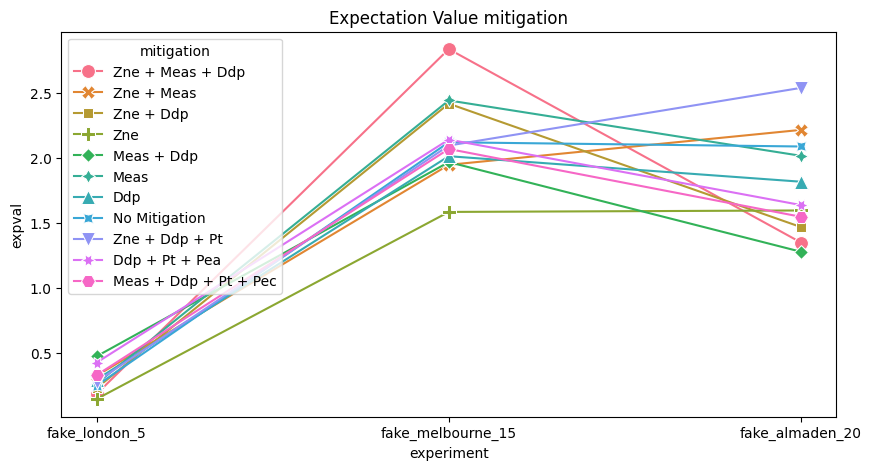

In [44]:
plt.figure(figsize=(10,5))
sns.lineplot(data=estimation_data, x="experiment", y="expval", hue="mitigation", markers=True, dashes=False, style="mitigation", markersize=10)
plt.title("Expectation Value mitigation")
plt.savefig(generate_full_file_path(OUTPUT_PATH, "mitgation-expval-comparasion-all-experiments.png"), bbox_inches='tight')
plt.show()

---

In [ ]:
def cut(circuits, backends):
    cuts = []
    pms = [generate_preset_pass_manager(backend=backend, optimization_level=3) for backend in backends]
    isa_qcs = []

    circuit_knitting_experiments_path = generate_full_file_path(OUTPUT_PATH, "knitting-experiments-results.json")
    circuit_knitting_cuts_path = generate_full_file_path(OUTPUT_PATH, "knitting-experiments-cuts.json")


    for circuit,pm in zip(circuits, pms):
        isa_qc = pm.run(circuit)
        isa_qcs.append(isa_qc)

        print('---Instruction positions---')
        for i, instruction in enumerate(isa_qc.data):
            instruction_qubits = [isa_qc.find_bit(q)[0] for q in instruction.qubits]
            if(len(instruction_qubits) != 2):
                continue
            print(i, instruction_qubits)
            
        display(isa_qc.draw('mpl'))
        

        cuts_distance = input("cuts for distance: ")
        cuts_cnot_error = input("cuts for cnot error: ")
        cuts.append([])
        cuts[-1].append(list(map(int, cuts_distance.split())))
        cuts[-1].append(list(map(int, cuts_cnot_error.split())))
        cuts[-1].append([*cuts[-1][0], *cuts[-1][1]])

    print(f"Using cuts: {cuts}")
    export_data_json(cuts, circuit_knitting_cuts_path)

    cuts_names = ['cuts-for-distance', 'cuts-for-cnot-error', 'cuts-for-both']

    results = {}

    for qc, qc_cuts, pm, backend in zip(isa_qcs, cuts, pms, backends):

        n_qubits = qc.num_qubits
        obs = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(n_qubits)], num_qubits=n_qubits)
        sampler = SamplerV2(backend=backend)
        
        for cut_type, cut in enumerate(qc_cuts):
            qc.remove_final_measurements()
            qc = qc.copy()

            cut_name = cuts_names[cut_type]
            cut_file_postfix = f'{n_qubits}qubits-{cut_name}'
            obj_index = cut_file_postfix.replace('-', '_')

            print(f"Running: {cut_file_postfix}")

            qpd_circuit, bases = cut_gates(qc, cut)
            qpd_circuit.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, f'ghz-{cut_file_postfix}.png'))

            subexperiments, coefficients = generate_cutting_experiments(
                circuits=qpd_circuit, observables=obs.paulis, num_samples=np.inf
            )
            isa_subexperiments = pm.run(subexperiments)
            job = sampler.run(isa_subexperiments)
            result = job.result()
            reconstructed_expval_terms = reconstruct_expectation_values(
                result,
                coefficients,
                obs.paulis,
            )
            expval = np.dot(reconstructed_expval_terms, obs.coeffs)

            results[obj_index] = float(expval)

            export_data_json(results, circuit_knitting_experiments_path)

    return results


In [11]:
two_qubits_filter = lambda x: len(x[1]) >= 2
for qc, backend in zip(ghz_circuits, backends):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    isa_qc = pm.run(qc)

    backend_name = backend.name
    print(f'---{backend_name}---')
    print(f'default circuit depth: {qc.depth(two_qubits_filter)}')
    print(f'transpiled circuit depth: {isa_qc.depth(two_qubits_filter)}')

---fake_london---
default circuit depth: 5
transpiled circuit depth: 8
---fake_melbourne---
default circuit depth: 15
transpiled circuit depth: 15
---fake_almaden---
default circuit depth: 20
transpiled circuit depth: 33


---Instruction positions---
1 [0, 1]
4 [2, 1]
7 [2, 1]
10 [1, 3]
11 [3, 4]


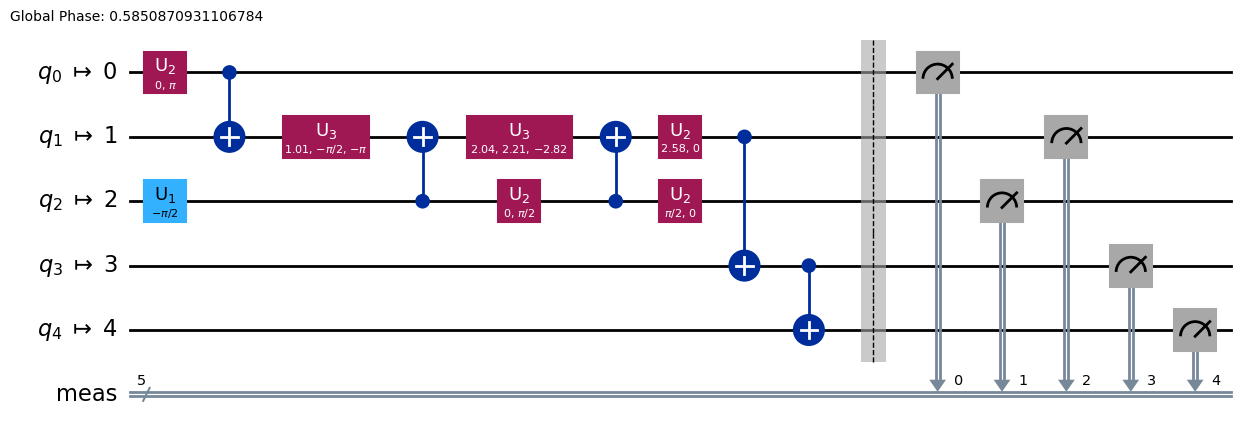

---Instruction positions---
3 [4, 3]
4 [3, 2]
5 [2, 1]
6 [1, 0]
7 [0, 14]
8 [14, 13]
9 [13, 12]
10 [12, 11]
11 [11, 10]
12 [10, 9]
13 [9, 5]
14 [5, 6]
15 [6, 8]
16 [8, 7]


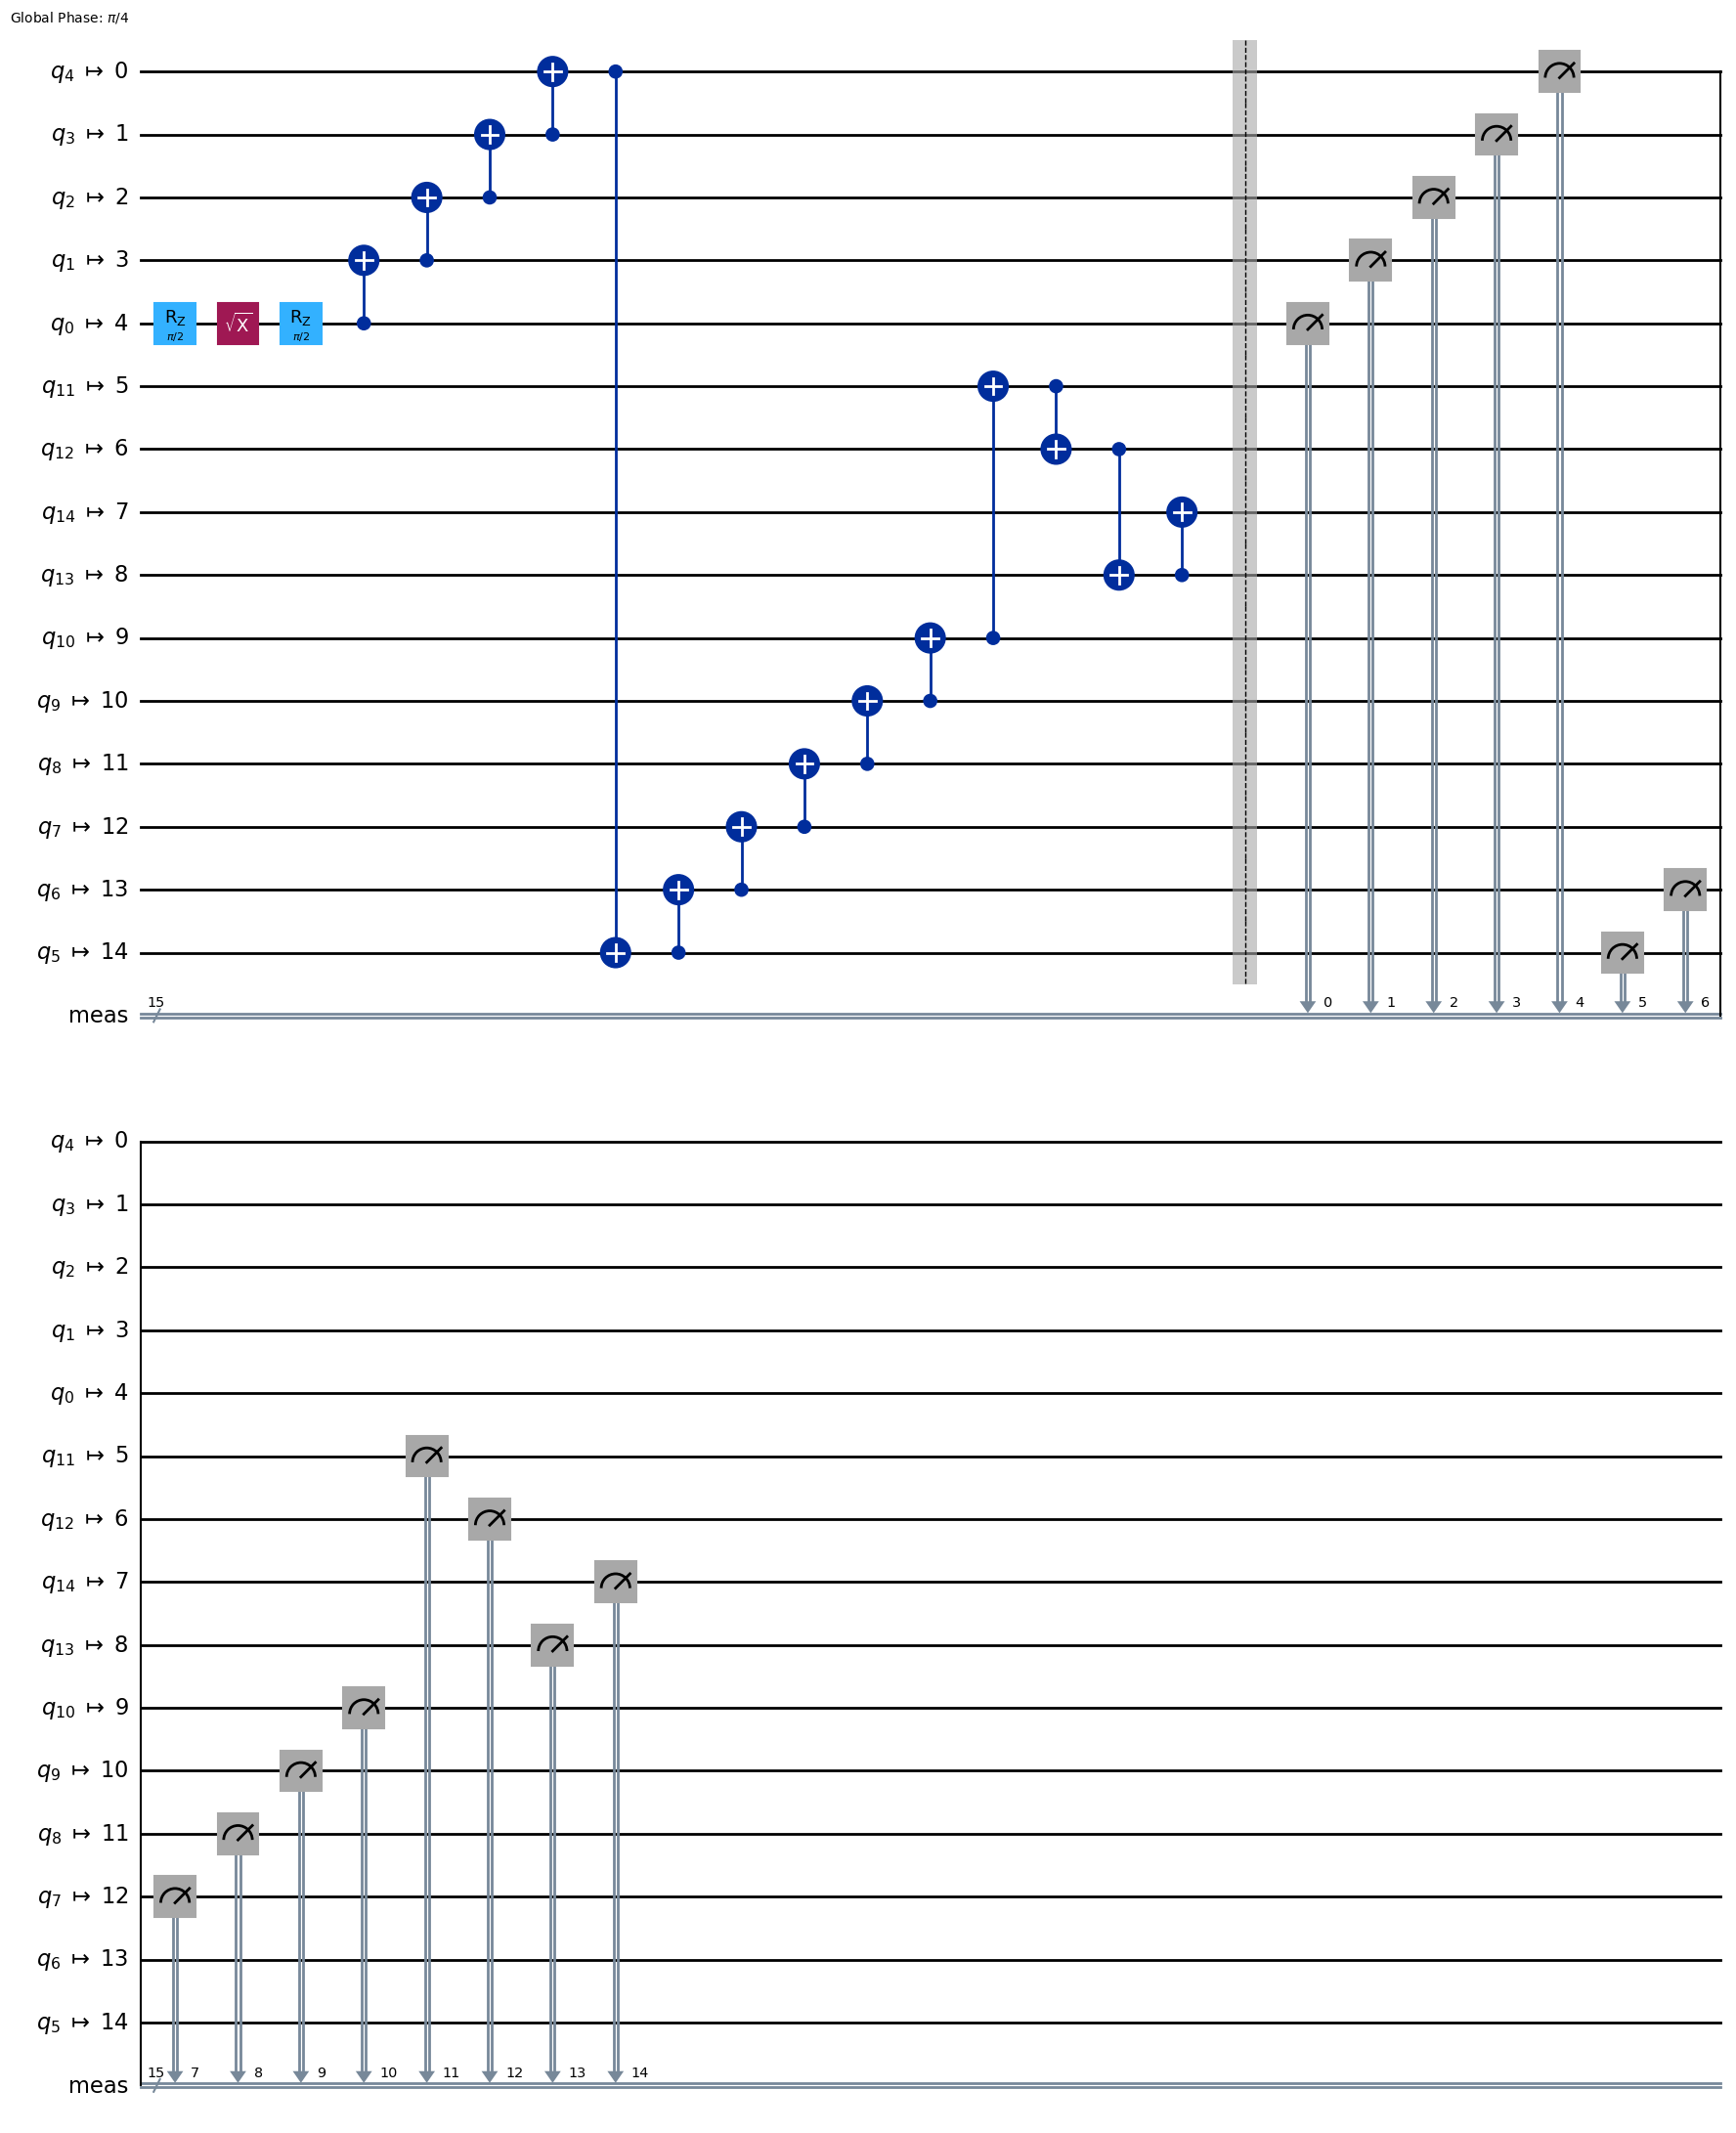

---Instruction positions---
2 [10, 5]
3 [5, 6]
4 [6, 1]
6 [0, 1]
9 [0, 1]
12 [1, 6]
13 [6, 1]
14 [1, 6]
15 [6, 7]
16 [7, 8]
17 [8, 3]
18 [3, 4]
19 [2, 3]
20 [3, 2]
21 [2, 3]
22 [4, 3]
23 [3, 8]
24 [8, 3]
25 [3, 8]
26 [8, 9]
27 [9, 14]
28 [14, 13]
30 [13, 18]
31 [18, 13]
32 [13, 18]
33 [18, 17]
34 [17, 18]
35 [18, 17]
36 [17, 16]
38 [16, 15]
41 [16, 15]
44 [16, 11]
45 [11, 12]
46 [12, 13]
47 [13, 18]
48 [18, 19]


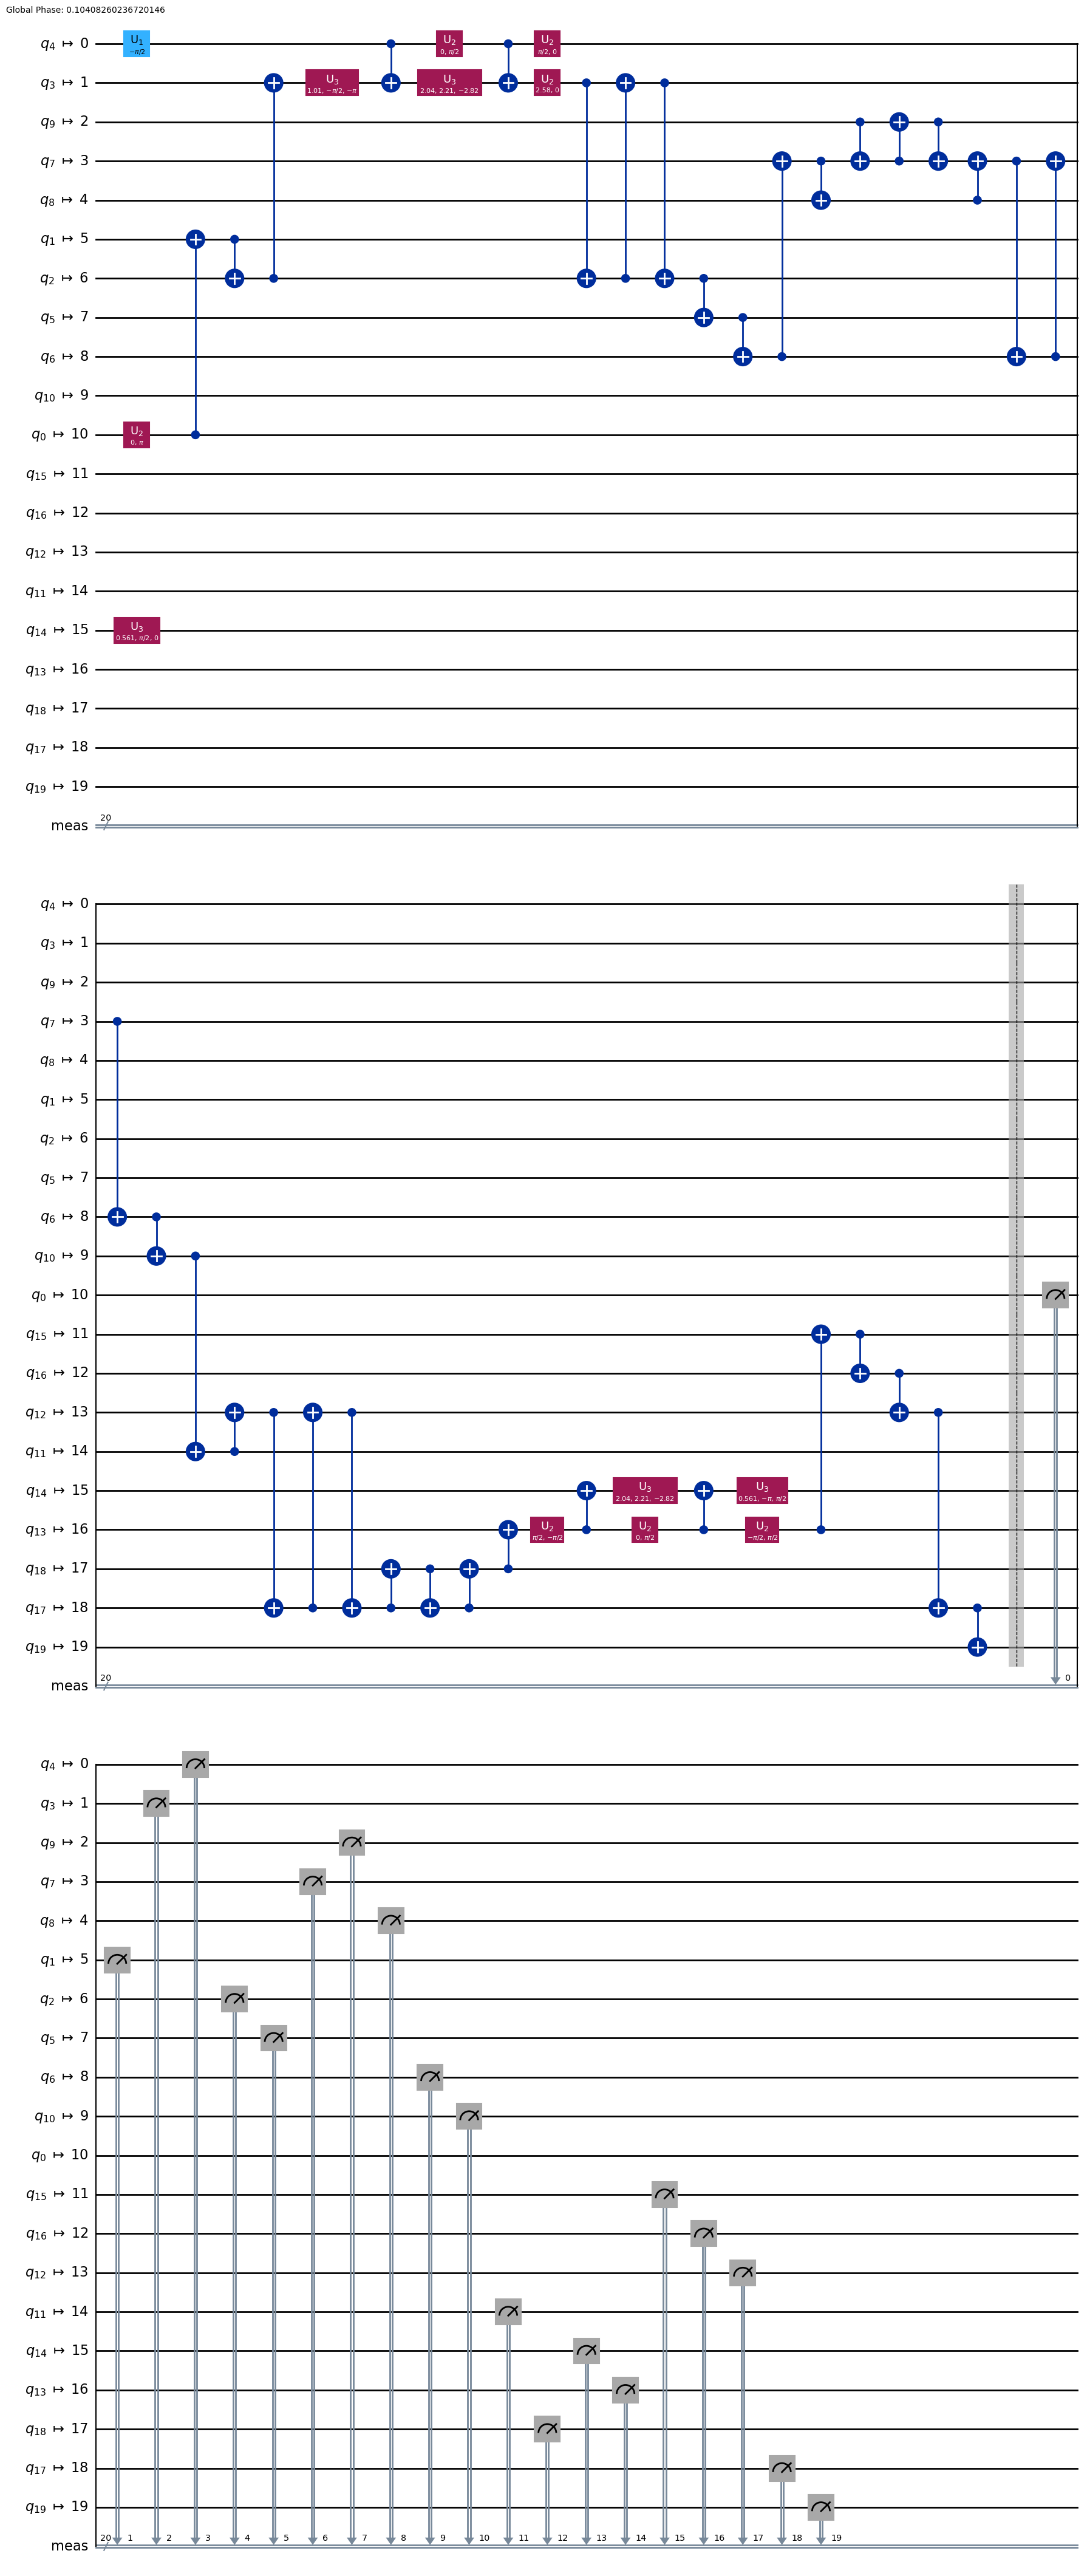

Using cuts: [[[10], [11], [10, 11]], [[7], [14], [7, 14]], [[27], [2], [27, 2]]]
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/knitting-experiments-cuts.json...
Running: 5qubits-$cuts-for-distance


/tmp/ipykernel_8161/2256906032.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  results[obj_index] = float(expval)


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/knitting-experiments-results.json...
Running: 5qubits-$cuts-for-cnot-error


/tmp/ipykernel_8161/2256906032.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  results[obj_index] = float(expval)


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/knitting-experiments-results.json...
Running: 5qubits-$cuts-for-both


/tmp/ipykernel_8161/2256906032.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  results[obj_index] = float(expval)


saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/ghz-test/knitting-experiments-results.json...
Running: 15qubits-$cuts-for-distance


KeyboardInterrupt: 

In [18]:
cut(ghz_circuits, backends)